In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')
from wordcloud import WordCloud
from textwrap import wrap
import unicodedata
from textblob import TextBlob

# Ruta de los datos
# "..\Data\Banco-Preguntas-Icfes.txt"

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\tarea\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tarea\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [19]:
file_path = "../Data/Banco-Preguntas-Icfes.txt"

# Leer el archivo línea por línea
with open(file_path, "r", encoding="utf-8") as file:
    lines = file.readlines()

# Mostrar las primeras 10 líneas para verificar el formato
print("Contenido del archivo (primeras 10 líneas):\n")
for i, line in enumerate(lines[:10]):
    print(f"Línea {i+1}: {line.strip()}")


Contenido del archivo (primeras 10 líneas):

Línea 1: Pregunta: ¿En qué fechas se dará inicio al proceso de registro e inscripción a los exámenes?
Línea 2: Respuesta: Validar en la página www.icfes.gov.co / Evaluaciones y Elija el examen de su interés.
Línea 3: 
Línea 4: Pregunta:¿Cómo puedo cambiar el correo de notificaciones asociado al usuario PRISMA de mi sede jornada?
Línea 5: Respuesta:A través del Chat, ingresando a la  página www.icfes.gov.co / Atención y servicios a la ciudadanía / canales de atención / Chat.(Link:https://www.icfes.gov.co/atencion-y-servicios-a-la-ciudadania/canales-de-atencion/)
Línea 6: 
Línea 7: Pregunta:¿qué debo hacer para presentar las pruebas icfes por segunda vez?
Línea 8: Respuesta:Se puede registrar las veces que desee, después de la quinta inscripción la tarifa aumenta, validar en  la página www.icfes.gov.co / Evaluaciones y Elija el examen de su interés.
Línea 9: 
Línea 10: Pregunta:¿El examen saber 11°, entrega certificado o constancia de asistenc

In [20]:
# 📌 1️⃣ Leer el archivo y contar palabras
with open(file_path, "r", encoding="utf-8") as file:
    contenido = file.read()

# 📌 2️⃣ Contar el total de palabras
total_palabras = len(contenido.split())

# 📌 3️⃣ Mostrar el resultado
print(f"📊 Total de palabras en el archivo: {total_palabras}")

📊 Total de palabras en el archivo: 1230


In [21]:
# 📌 1️⃣ Inicializar listas para almacenar preguntas y respuestas
preguntas = []
respuestas = []
pregunta_actual = ""
respuesta_actual = ""
leyendo_respuesta = False

# 📌 2️⃣ Leer el archivo línea por línea y separar preguntas y respuestas
with open(file_path, "r", encoding="utf-8") as file:
    for line in file:
        line = line.strip()

        # Detectar preguntas
        if line.startswith("Pregunta:"):
            if pregunta_actual:
                preguntas.append(pregunta_actual.strip())
                respuestas.append(respuesta_actual.strip())
            pregunta_actual = line.replace("Pregunta:", "").strip()
            respuesta_actual = ""
            leyendo_respuesta = False

        # Detectar respuestas
        elif line.startswith("Respuesta:"):
            leyendo_respuesta = True
            respuesta_actual = line.replace("Respuesta:", "").strip()

        # Agregar contenido a la pregunta o respuesta
        else:
            if leyendo_respuesta:
                respuesta_actual += " " + line.strip()
            else:
                pregunta_actual += " " + line.strip()

# 📌 3️⃣ Agregar la última pregunta y respuesta
if pregunta_actual:
    preguntas.append(pregunta_actual.strip())
    respuestas.append(respuesta_actual.strip())

# 📌 4️⃣ Crear DataFrames separados para preguntas y respuestas
df_preguntas = pd.DataFrame({"Pregunta": preguntas})
df_respuestas = pd.DataFrame({"Respuesta": respuestas})

# 📌 5️⃣ Mostrar las primeras filas de cada DataFrame
print("\n📊 Primeras preguntas extraídas:")
print(df_preguntas.head())

print("\n📊 Primeras respuestas extraídas:")
print(df_respuestas.head())

# 📌 6️⃣ Mostrar el número total de preguntas y respuestas extraídas
print(f"\nTotal de preguntas extraídas: {len(df_preguntas)}")
print(f"Total de respuestas extraídas: {len(df_respuestas)}")


📊 Primeras preguntas extraídas:
                                            Pregunta
0  ¿En qué fechas se dará inicio al proceso de re...
1  ¿Cómo puedo cambiar el correo de notificacione...
2  ¿qué debo hacer para presentar las pruebas icf...
3  ¿El examen saber 11°, entrega certificado o co...
4                       ¿Debo pagar las pruebas TyT?

📊 Primeras respuestas extraídas:
                                           Respuesta
0  Validar en la página www.icfes.gov.co / Evalua...
1  A través del Chat, ingresando a la  página www...
2  Se puede registrar las veces que desee, despué...
3  No, únicamente se genera certificado de asiste...
4  Valida las tarifas en la página www.icfes.gov....

Total de preguntas extraídas: 26
Total de respuestas extraídas: 26


# Punto critico de limpieza, se borra los caracteres especiales, tildes, numeros y se pasa todo a minusculas
Nota: para entregar los datos al RAG se puesden guardar un mapeo de los datos originales y el modelo trabaje con los datos limpios, y antes de entregar la respuesta al usuario busque en el mapeo el dato original y lo devuelva al usuario

```python

In [22]:
# 📌 1️⃣ Función para limpiar el texto
def limpiar_texto(texto):
    if pd.isna(texto):  # Verificar si el texto es NaN o None
        return ""
    
    texto = str(texto).lower()  # Convertir a minúsculas
    texto = unicodedata.normalize('NFKD', texto).encode('ASCII', 'ignore').decode('utf-8')  # Eliminar tildes
    texto = re.sub(r'\d+', '', texto)  # Eliminar números
    texto = re.sub(r'[^\w\s]', '', texto)  # Eliminar caracteres especiales
    texto = re.sub(r'\b[a-zA-Z]\b', '', texto)  # Eliminar palabras de 1 solo carácter
    texto = re.sub(r'\s+', ' ', texto).strip()  # Eliminar espacios extra
    
    return texto

# 📌 2️⃣ Aplicar la función de limpieza a los DataFrames
df_preguntas["Pregunta"] = df_preguntas["Pregunta"].apply(limpiar_texto)
df_respuestas["Respuesta"] = df_respuestas["Respuesta"].apply(limpiar_texto)

# 📌 3️⃣ Mostrar las primeras filas de los DataFrames limpios
print("\nPrimeras preguntas limpias:")
print(df_preguntas.head())

print("\nPrimeras respuestas limpias:")
print(df_respuestas.head())



Primeras preguntas limpias:
                                            Pregunta
0  en que fechas se dara inicio al proceso de reg...
1  como puedo cambiar el correo de notificaciones...
2  que debo hacer para presentar las pruebas icfe...
3  el examen saber entrega certificado constancia...
4                         debo pagar las pruebas tyt

Primeras respuestas limpias:
                                           Respuesta
0  validar en la pagina wwwicfesgovco evaluacione...
1  traves del chat ingresando la pagina wwwicfesg...
2  se puede registrar las veces que desee despues...
3  no unicamente se genera certificado de asisten...
4  valida las tarifas en la pagina wwwicfesgovco ...


Nube de palabras - Preguntas


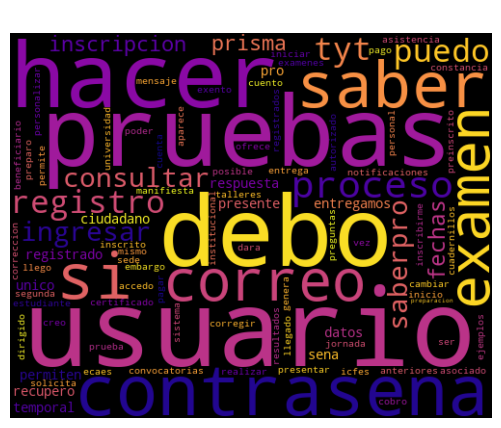

Nube de palabras - Respuestas


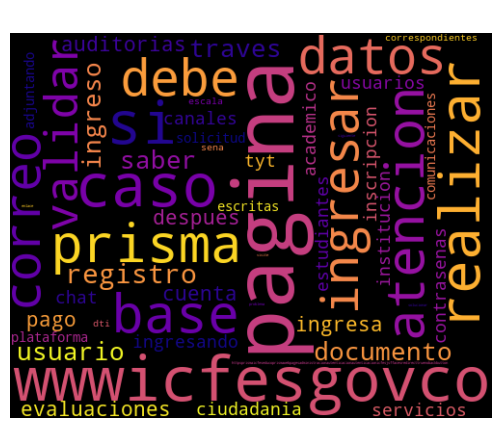

In [23]:
stop_words = set(stopwords.words("spanish"))

# 📌 2️⃣ Función para limpiar y tokenizar sin `word_tokenize()`
def tokenizar_y_filtrar(texto):
    tokens = re.findall(r'\b\w+\b', texto.lower())  # Extraer solo palabras
    tokens = [word for word in tokens if word not in stop_words]  # Filtrar stopwords
    return tokens

# 📌 3️⃣ Tokenizar preguntas y respuestas
tokens_preguntas = [token for pregunta in df_preguntas["Pregunta"] for token in tokenizar_y_filtrar(pregunta)]
tokens_respuestas = [token for respuesta in df_respuestas["Respuesta"] for token in tokenizar_y_filtrar(respuesta)]

# 📌 4️⃣ Contar la frecuencia de palabras
frecuencia_preguntas = Counter(tokens_preguntas)
frecuencia_respuestas = Counter(tokens_respuestas)

# 📌 5️⃣ Función para generar nubes de palabras
def generar_nube_palabras(frecuencia_palabras, titulo):
    wordcloud = WordCloud(
        width=500, height=400, 
        background_color="black", 
        colormap="plasma", 
        max_words=100
    ).generate_from_frequencies(frecuencia_palabras)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(titulo, fontsize=14, color="white")
    plt.show()

# 📌 6️⃣ Generar nubes de palabras para preguntas y respuestas
print("Nube de palabras - Preguntas")
generar_nube_palabras(frecuencia_preguntas, "Nube de Palabras - Preguntas")
print("Nube de palabras - Respuestas")
generar_nube_palabras(frecuencia_respuestas, "Nube de Palabras - Respuestas")

C:\Users\tarea\AppData\Local\Temp\ipykernel_24864\1184692185.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(frecuencias), y=list(palabras), palette="viridis")


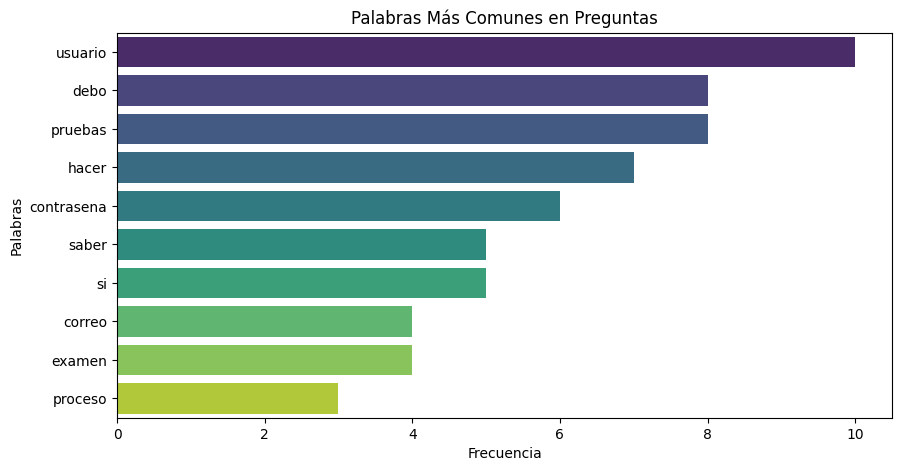

C:\Users\tarea\AppData\Local\Temp\ipykernel_24864\1184692185.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(frecuencias), y=list(palabras), palette="viridis")


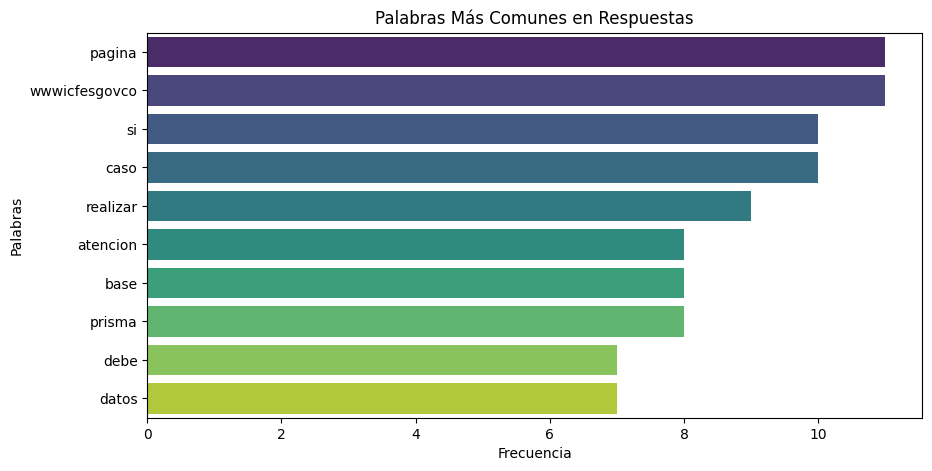

In [24]:
# 📌 4️⃣ Obtener las 10 palabras más comunes
top_preguntas = frecuencia_preguntas.most_common(10)
top_respuestas = frecuencia_respuestas.most_common(10)


# 📌 5️⃣ Función para graficar palabras más comunes
def graficar_palabras_comunes(palabras_comunes, titulo):
    palabras, frecuencias = zip(*palabras_comunes)
    plt.figure(figsize=(10, 5))
    sns.barplot(x=list(frecuencias), y=list(palabras), palette="viridis")
    plt.title(titulo)
    plt.xlabel("Frecuencia")
    plt.ylabel("Palabras")
    plt.show()

# 📌 6️⃣ Generar gráficos para preguntas y respuestas
graficar_palabras_comunes(top_preguntas, "Palabras Más Comunes en Preguntas")
graficar_palabras_comunes(top_respuestas, "Palabras Más Comunes en Respuestas")

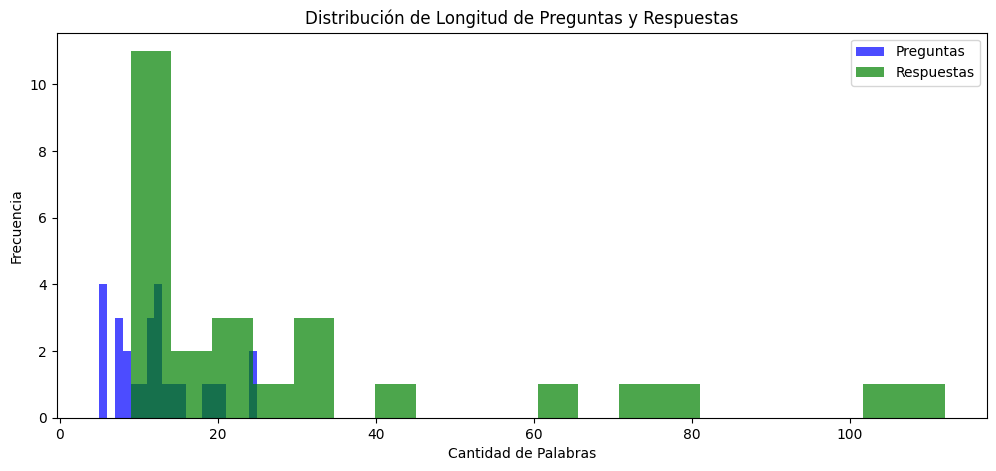

In [25]:
# Contar la cantidad de palabras en preguntas y respuestas
df_preguntas["Longitud_Pregunta"] = df_preguntas["Pregunta"].apply(lambda x: len(x.split()))
df_respuestas["Longitud_Respuesta"] = df_respuestas["Respuesta"].apply(lambda x: len(x.split()))

# Visualizar la distribución de longitudes
plt.figure(figsize=(12, 5))
plt.hist(df_preguntas["Longitud_Pregunta"], bins=20, alpha=0.7, label="Preguntas", color="blue")
plt.hist(df_respuestas["Longitud_Respuesta"], bins=20, alpha=0.7, label="Respuestas", color="green")
plt.xlabel("Cantidad de Palabras")
plt.ylabel("Frecuencia")
plt.title("Distribución de Longitud de Preguntas y Respuestas")
plt.legend()
plt.show()


In [26]:
# Función para analizar sentimiento
def analizar_sentimiento(texto):
    return TextBlob(texto).sentiment.polarity  # Devuelve un valor entre -1 (negativo) y 1 (positivo)

# Aplicar análisis a preguntas y respuestas
df_preguntas["Sentimiento"] = df_preguntas["Pregunta"].apply(analizar_sentimiento)
df_respuestas["Sentimiento"] = df_respuestas["Respuesta"].apply(analizar_sentimiento)

# Mostrar resultados
print("\n📊 Distribución de sentimiento en preguntas:")
print(df_preguntas["Sentimiento"].describe())

print("\n📊 Distribución de sentimiento en respuestas:")
print(df_respuestas["Sentimiento"].describe())




📊 Distribución de sentimiento en preguntas:
count    26.0
mean      0.0
std       0.0
min       0.0
25%       0.0
50%       0.0
75%       0.0
max       0.0
Name: Sentimiento, dtype: float64

📊 Distribución de sentimiento en respuestas:
count    26.000000
mean     -0.123077
std       0.294357
min      -0.800000
25%       0.000000
50%       0.000000
75%       0.000000
max       0.000000
Name: Sentimiento, dtype: float64


In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

# 📌 1️⃣ Definir el vectorizador TF-IDF
vectorizer = TfidfVectorizer()

# 📌 2️⃣ Convertir preguntas en vectores numéricos
tfidf_matrix = vectorizer.fit_transform(df_preguntas["Pregunta"])

# 📌 3️⃣ Aplicar K-Means para agrupar preguntas
num_clusters = 6  # Número de categorías
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
df_preguntas["Cluster"] = kmeans.fit_predict(tfidf_matrix)



In [ ]:
# --- Obtener el vocabulario invertido (índice -> palabra) ---
vocabulario_invertido = {indice: palabra for palabra, indice in vectorizer.vocabulary_.items()}

# --- Iterar sobre la matriz dispersa ---
print("Elementos no nulos de la matriz TF-IDF (con preguntas):")

for i in range(tfidf_matrix.shape[0]):  # Itera sobre las filas (preguntas)
    #La siguiente linea itera sobre los indices de las columnas que SI tienen valores
    for j in tfidf_matrix.indices[tfidf_matrix.indptr[i]:tfidf_matrix.indptr[i+1]]:
        pregunta = df_preguntas["Pregunta"].iloc[i]
        palabra = vocabulario_invertido[j]
        valor_tfidf = tfidf_matrix[i, j]

        print(f"Pregunta: '{pregunta}', Palabra: '{palabra}', Coordenada: ({i}, {j}), Valor TF-IDF: {valor_tfidf}")

In [28]:
# 📌 4️⃣ Mostrar ejemplos de cada grupo
for cluster in range(num_clusters):
    print(f"\n📌 Categoría {cluster}:")
    print(df_preguntas[df_preguntas["Cluster"] == cluster]["Pregunta"].head(5))


📌 Categoría 0:
1     como puedo cambiar el correo de notificaciones...
8     como puedo consultar mi usuario contrasena tem...
9     como puedo consultar mi usuario contrasena tem...
12    donde es posible consultar el estado de un est...
16                           como creo mi usuario unico
Name: Pregunta, dtype: object

📌 Categoría 1:
23    que son las pruebas saberpro es lo mismo que e...
24    como accedo los resultados de las pruebas sabe...
25    la universidad ofrece talleres de preparacion ...
Name: Pregunta, dtype: object

📌 Categoría 2:
3     el examen saber entrega certificado constancia...
5               quien esta dirigido el examen saber tyt
19    como me preparo para el examen con cuadernillo...
Name: Pregunta, dtype: object

📌 Categoría 3:
11    si al personalizar el usuario me aparece un me...
21       ya presente la prueba saber pro que debo hacer
Name: Pregunta, dtype: object

📌 Categoría 4:
0     en que fechas se dara inicio al proceso de reg...
13    que respue

In [29]:
print(df_preguntas["Pregunta"])

0     en que fechas se dara inicio al proceso de reg...
1     como puedo cambiar el correo de notificaciones...
2     que debo hacer para presentar las pruebas icfe...
3     el examen saber entrega certificado constancia...
4                            debo pagar las pruebas tyt
5               quien esta dirigido el examen saber tyt
6     que debo hacer si fui registrado para las prue...
7     si cuento con el usuario contrasena no permite...
8     como puedo consultar mi usuario contrasena tem...
9     como puedo consultar mi usuario contrasena tem...
10    si cuenta con el usuario contrasena no permite...
11    si al personalizar el usuario me aparece un me...
12    donde es posible consultar el estado de un est...
13    que respuesta le entregamos un ciudadano que s...
14    como realizar la correccion de datos fuera de ...
15    que respuesta le entregamos un ciudadano que m...
16                           como creo mi usuario unico
17                       como recupero mi usuari

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# 📌 1️⃣ Vectorizar las respuestas con TF-IDF
vectorizer = TfidfVectorizer()
tfidf_matrix_respuestas = vectorizer.fit_transform(df_respuestas["Respuesta"])

# 📌 2️⃣ Calcular similitud entre respuestas
similaridades_respuestas = cosine_similarity(tfidf_matrix_respuestas)

# 📌 3️⃣ Encontrar pares de respuestas muy similares
indices_respuestas_similares = np.argwhere(similaridades_respuestas > 0.85)  # Umbral de similitud alta
        
# 📌 5️⃣ Mostrar respuestas similares sin duplicados
print("\n📌 🔍 Respuestas muy similares detectadas:")
pares_mostrados = set()

for i, j in indices_respuestas_similares:
    if i < j:  # Solo una vez cada par (para evitar duplicados)
        par = (i, j)
        if par not in pares_mostrados:
            pares_mostrados.add(par)
            print(f"- Respuesta 1: {df_respuestas.iloc[i]['Respuesta']}")
            print(f"- Respuesta 2: {df_respuestas.iloc[j]['Respuesta']}\n")



📌 🔍 Respuestas muy similares detectadas:
- Respuesta 1: validar con el programa academico si estan correctas de lo contrario contactarse las lineas de atencion ingresando la pagina wwwicfesgovco atencion servicios la ciudadania canales de atencion linea nacional bogota traves del chat
- Respuesta 2: validarlo con el programa academico de lo contrario contactarse las lineas de atencion ingresando la pagina wwwicfesgovco atencion servicios la ciudadania canales de atencion linea nacional bogota traves del chat

